# Assignment 2
*Markov Decision Processes*  
Assignment 2 of 5 submitted  
Assignment 1: Dueling Bandits

Vasken Dermardiros (ID: 260236302)  
Reinforcement Learning COMP767 @ RLLAB McGill Winter 2018 Session  
Profs. Doina Precup & Pierre-Luc Bacon  

# Introduction
This assignment will cover Markov Decision Processes (MDP). Unlike last time, we don't need to review a particular paper but instead make use of Puterman's MDP book [1].

We've chosen to go with **Track 1** problem on top of answering the mandatory questions.

#### Reference
[1] Puterman, Martin L. (1994). *Markov Decision Processes: Discrete Stochastic Dynamic Programming*. John Wiley & Sons, Inc.

# Mandatory Questions
## Bellman Optimality Equations
"""Using a contraction argument, show that there exists a solution to the Bellman optimality
equations. That is: show that the Bellman optimality operator is a contraction mapping."""


Contraction mapping, reproduced from [slide 17](https://www.cs.cmu.edu/~katef/DeepRLControlCourse/lectures/lecture3_mdp_planning.pdf): : an operator $F$ on a normed vector space $\mathcal{X}$ is a $\gamma$-contraction, for $0 < \gamma < 1$, provided $\forall x, y \in \mathcal{X}$  

$$
\lVert T(x)-T(y) \rVert \leq \gamma \lVert x-y \rVert.
$$  

$F$ converges to a unique fixed point in $\mathcal{X}$ at linear convergence rate $\gamma$.

In class, Doina used the infinity-norm:

$$
\Vert \mathbf{x} \rVert_\infty := \underset{i}{\mathrm{max}} \lvert x_i \rvert
$$

The Bellman expectation equation, eq. 6.1.6, p.144 from Puterman [1], with harmonized notation:

$$
F^\pi(v) := v = r^\pi + \gamma P^\pi v
$$

Where $r$ is the reward, $P$ the transition probability matrix and $\pi$ the policy. We need to show that the equation above is a contraction mapping. Following the mapping definition, we obtain, for state-value functions $a$ and $b$:

$$
\begin{aligned}
\lVert F^\pi(a)-F^\pi(b) \rVert_\infty &= \lVert r^\pi+\gamma P^\pi a \rVert_\infty - \lVert r^\pi+\gamma P^\pi b \rVert_\infty \\
&= \lVert \gamma P^\pi (a-b) \rVert_\infty \\
&\leq \lVert \gamma P^\pi \lVert a-b \rVert_\infty \rVert_\infty \\
&\leq \gamma \lVert a-b \rVert_\infty \\
\end{aligned}
$$

## Policy Iteration
"""Show that the values of two successive policies generated by policy iteration are nondecreasing. Assume a finite MDP and conclude (explain why) that policy iteration must terminate under a finite number of steps. Finally, show that upon termination, policy iteration must have found an optimal policy (ie. one which satisfies the optimality equations)."""


First, let's assume we can evaluate $\mathcal{v}_\pi$ given $\pi$ using *policy evaluation*. Next, by defining:  

$$
\pi'(s) := \underset{a}{\mathrm{argmin}}~q_\pi(s,a)
$$

we argue that we can take an action $a$ that will result in a higher value under policy $\pi$:

$$
q_\pi(s,\pi'(s)) \geq \mathcal{v}_\pi(s)  \\
\mathcal{v}_{\pi'}(s) \geq \mathcal{v}_\pi(s)
$$

for at least one state $s$. [To make action-value term equal to value term, please consult Sutton book p.61 the equations right after 4.8]. Therefore the value of the policy keeps increasing or doesn't change. Since the MDP is finite with countable states and countable actions, the upper bound on the number of iterations needed is equal to:

$$
\lvert states^ {\lvert actions \rvert} \rvert 
$$

which is a finite number. So even by brute force evaluation, we would get to the optimal in that many calculations. Since it's a finite and stationary MDP, if the value $\mathcal{v}_{\pi'} = \mathcal{v}_{\pi}$, meaning the value has converged, then it must be that $\mathcal{v}_{\pi'} = \mathcal{v}^*$, the optimal value and the policy $\pi' = \pi^*$ is optimal.

---

# Track 1
**Objective**. Implement and compare policy iteration, modified policy iteration and value iteration RL techniques. Apply it to the simple 2-state MDP in the assignment description [reproduced below] and also run it on a -- we chose -- a gridworld MDP. Explain and explore how the convergence rate is affected by the discount factor.

![Assignment MDP](img/mdp.png)

# Implementation
Onto Python then! We begin with importing numpy and not use scientific notation because we don't care about tiny numbers here.

We will start with the policy iterations and then the value iteration for the MDP and then for the gridworld.

*Disclaimer: I was already working on the policy/value iteration problems before the assignment and was following DennyBritz' example files. Since I had already used them, I simply copied them here. There are overlaps between this assignment and his examples. I just want to be 100% transparent is all.*

In [1]:
# Code written in Python 2
import numpy as np
import pprint
np.set_printoptions(precision=4)

pp = pprint.PrettyPrinter(indent=2)
# Import the gridworld environment from DennyBritz' repo
# [https://github.com/dennybritz/reinforcement-learning]
from lib_DennyBritz.envs.gridworld import GridworldEnv

In [2]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Global variable to count the number of policy evaluation iterations
    global count_PE    
    
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                if a in env.P[s].keys(): # is the action possible?
                    # For each action, look at the possible next states...
                    for prob, next_state, reward, done in env.P[s][a]:
                        # Calculate the expected value
                        v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        
        # Increment policy improvement counter
        count_PE += 1
            
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)


def modified_policy_eval(policy, env, discount_factor=1.0, theta=0.00001, m=50):
    """
    Partially evaluate a policy given an environment and a full description of the environment's dynamics.
    Policy evaluation is limited to an "m" number of iterations or until convergence, whichever occurs first.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Global variable to count the number of policy evaluation iterations
    global count_PE
    
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    n = 0 # iteration number
    while n <= m: # iteration-based stopping criterion
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                if a in env.P[s].keys(): # is the action possible?
                    # For each action, look at the possible next states...
                    for prob, next_state, reward, done in env.P[s][a]:
                        # Calculate the expected value
                        v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)            
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        n += 1 # increment counter
        
        # Increment policy improvement counter
        count_PE += 1
        
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)


def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        policy_stable = True
        # For each state
        for s in range(env.nS):
            old_action = np.argmax(policy[s])
            action_values = np.zeros(env.nA)
            
            # Look at the possible next actions
            # for a, __ in enumerate(policy[s]):
            # for a in range(env.nA):
            for a in env.P[s].keys(): # only go through possible actions, rest is "0"  
                
                # For each action, look at the possible next states...     
                for prob, next_state, reward, done in env.P[s][a]:           
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
                    
            # Only select actions that are possible. Sort actions and return 1st best valid action.
            for a_maybe in np.argsort(action_values)[::-1]:
                if a_maybe in env.P[s].keys():
                    new_action = a_maybe
                    break
                
            # Greedily update the policy
            if old_action != new_action:
                policy_stable = False
            policy[s] = np.eye(env.nA)[new_action]

        if policy_stable:
            return policy, V
        
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    # Global variable to count the number of policy evaluation iterations
    global count_PE
    
    V = np.zeros(env.nS)
    
    # Implement!
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            action_values = np.zeros(env.nA)
            # Look at the possible next actions
            # for a in range(env.nA):
            for a in env.P[s].keys(): # only go through possible actions, rest is "0"
                # For each action, look at the possible next states...
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            v = np.max(action_values[env.P[s].keys()])
            
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
                
        # Increment policy improvement counter
        count_PE += 1
        
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:            
            break

    policy = np.zeros([env.nS, env.nA])
    # and output a gready deterministic policy
    for s in range(env.nS):
        action_values = np.zeros(env.nA)            
        # Look at the possible next actions
        # for a in range(env.nA):
        for a in env.P[s].keys(): # only go through possible actions, rest is "0"  
            # For each action, look at the possible next states...     
            for prob, next_state, reward, done in env.P[s][a]:           
                action_values[a] += prob * (reward + discount_factor * V[next_state])
        # new_action = np.argmax(action_values)
        # Only select actions that are possible. Sort actions and return 1st best valid action.
        for a_maybe in np.argsort(action_values)[::-1]:
            if a_maybe in env.P[s].keys():
                new_action = a_maybe
                break
        policy[s] = np.eye(env.nA)[new_action]
    
    return policy, V

# from IPython.core.debugger import Tracer; Tracer()() 

---
## 2-State MDP

In [3]:
# Let's first create the environment
class TwoStateMDP():
    '''
    Transition Probabilities: P(s_0 | s_0, a_0) = 0.5, 
                              P(s_0 | s_0, a_1) = 0.,
                              P(s_1 | s_0, a_0) = 0.5, 
                              P(s_1 | s_0, a_1) = 1, 
                              P(s_1 | s_0, a_2) = 0, 
                              P(s_1 | s_1, a_2) = 1
    (State s_0 has access to actions a_0 and a_1, while in state s_1 the agent can only choose a_2. 
    As Preeti Vyas commented, the probabilities are simply zero for the actions that cannot be 
    taken.)
    Rewards: r(s_0, a_0) = 5, r(s_0, a_1) = 10, r(s_1, a_2) = -1
    Discount factor : 0.95

    '''

    def __init__(self):
        nS = 2 # number of states
        nA = 3 # number of possible actions
        
        P = {}
        # Since the MDP isn't large, I'll just configure it in manually...
        # P[s]: for state "s", we have actions
        # {a: [(prob_to_land_in_s', next_state, reward, done)]}: for action "a"
        # if the action isn't possible, we won't account for it in the policy and value iteration processes
        P[0] = {0: [(0.5, 1, 5., False),(0.5, 0, 5., False)], 1: [(1., 1, 10., False)]}
        P[1] = {2: [(1., 1, -1., False)]}

        self.nS, self.nA, self.P = nS, nA, P

In [4]:
env = TwoStateMDP()
discount_factor_MDP = 0.95

In [5]:
# Policy Iteration
global count_PE # policy evaluation count, policy improvement is cheap to computer
                # not best practice but this simplifies my life
count_PE = 0    # reset counter
policy, v = policy_improvement(env, discount_factor=discount_factor_MDP)

print("Number of Policy Evaluations: %i"% count_PE)
print("")

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

Number of Policy Evaluations: 464

Policy Probability Distribution:
[[ 1.  0.  0.]
 [ 0.  0.  1.]]

Value Function:
[ -8.5712 -19.9998]



In [6]:
# Modified Policy Iteration
# m = 50 for all n
global count_PE # policy evaluation count, policy improvement is cheap to computer
count_PE = 0    # reset counter
policy, v = policy_improvement(env, policy_eval_fn=modified_policy_eval, discount_factor=discount_factor_MDP)

print("Number of Policy Evaluations: %i"% count_PE)
print("")

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

Number of Policy Evaluations: 114

Policy Probability Distribution:
[[ 1.  0.  0.]
 [ 0.  0.  1.]]

Value Function:
[ -7.1095 -18.538 ]



In [7]:
# Value Iteration
global count_PE # policy evaluation count, policy improvement is cheap to computer
count_PE = 0    # reset counter
policy, v = value_iteration(env, discount_factor=discount_factor_MDP)

print("Number of Policy Evaluations: %i"% count_PE)
print("")

print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

Number of Policy Evaluations: 181

Policy Probability Distribution:
[[ 1.  0.  0.]
 [ 0.  0.  1.]]

Value Function:
[ -8.5696 -19.9981]



Let's see how the discount factor affects the convergence rate. Mind you, the modified policy iteration has $m$ fixed. We will sweep through different discount factors and plot the result.

In [8]:
gamma = [0.5, 0.75, 0.80, 0.85, 0.90, 0.95, 0.98, 0.99]
num_tests = len(gamma)
tally_PE = np.zeros((num_tests, 3)) # pi, mod pi, vi

for i, df in enumerate(gamma):
    count_PE = 0
    policy_improvement(env, discount_factor=df)
    tally_PE[i,0] = count_PE
    
    count_PE = 0
    policy_improvement(env, policy_eval_fn=modified_policy_eval, discount_factor=df)
    tally_PE[i,1] = count_PE
    
    count_PE = 0
    value_iteration(env, discount_factor=df)
    tally_PE[i,2] = count_PE
    
print tally_PE

[[   26.    26.    15.]
 [   52.    52.    34.]
 [   63.    61.    43.]
 [   83.    62.    58.]
 [  122.    62.    89.]
 [  464.   114.   181.]
 [ 1154.   114.   457.]
 [ 2306.   114.   918.]]


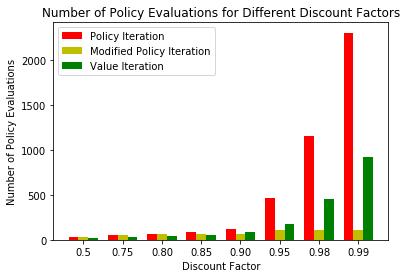

In [9]:
# Let's plot it instead!
import matplotlib.pyplot as plt
%matplotlib inline

ind = np.arange(num_tests)  # the x locations for the groups
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tally_PE[:,0], width, color='r')
rects2 = ax.bar(ind + width, tally_PE[:,1], width, color='y')
rects3 = ax.bar(ind + 2*width, tally_PE[:,2], width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Policy Evaluations')
ax.set_xlabel('Discount Factor')
ax.set_title('Number of Policy Evaluations for Different Discount Factors')
ax.set_xticks(ind + width)
ax.set_xticklabels(('0.5', '0.75', '0.80', '0.85', '0.90', '0.95', '0.98', '0.99'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('Policy Iteration', 'Modified Policy Iteration', 'Value Iteration'))

As it can be seen from the bar chart (or the printout), the higher the discount factor, the more policy evaluations. Why? Because a larger discount factor means our agent cares more about future rewards and so it has to look further, which results in more computation. The case for the modified policy evaluation, the number plateau since we've fixed the number of evaluation to $m$.

Now let's see if the values and policy for $\gamma=0.50$ is the same as when $\gamma=0.95$.

In [10]:
# Policy Iteration comparison
# 0.50 Discount Factor
policy, v = policy_improvement(env, discount_factor=0.50)
print("0.50 Discount Factor")
print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

# 0.95 Discount Factor
policy, v = policy_improvement(env, discount_factor=0.95)
print("0.95 Discount Factor")
print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

0.50 Discount Factor
Policy Probability Distribution:
[[ 0.  1.  0.]
 [ 0.  0.  1.]]

Value Function:
[ 9. -2.]

0.95 Discount Factor
Policy Probability Distribution:
[[ 1.  0.  0.]
 [ 0.  0.  1.]]

Value Function:
[ -8.5712 -19.9998]



Nope. Not the same. So what is happening? Well, the short-sighted agent ($\gamma=0.50$) is choosing action 1 over action 0. Action 1 has a higher immediate reward (10) over action 0 (5), so it takes it. However, on the long run, the far sighted agent sees the other path to be more lucrative.

---
## Gridworld
Now, let's apply the policy and value improvement iterations to the gridworld problem. I'm still using "env" as the environment variable; make sure to run the cell just below before proceeding, otherwise we'll still be using the 2-state MDP from above and given a default discount factor of 1.0, the process will loop forever.

In [11]:
env = GridworldEnv()

In [12]:
# Policy Iteration
policy, v = policy_improvement(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[3 3 3 3]
 [0 3 3 2]
 [0 3 2 2]
 [1 1 1 3]]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [13]:
# Modified Policy Iteration
policy, v = policy_improvement(env, policy_eval_fn=modified_policy_eval)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[3 3 3 3]
 [0 3 3 2]
 [0 3 2 2]
 [1 1 1 3]]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [14]:
# Value Iteration
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[3 3 3 3]
 [0 3 3 2]
 [0 3 2 2]
 [1 1 1 3]]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



Let's run the same test as the MDP here to compare discount factor to number of iterations needed.

In [15]:
gamma = [0.5, 0.75, 0.80, 0.85, 0.90, 0.95, 0.98, 1.]
num_tests = len(gamma)
tally_PE = np.zeros((num_tests, 3)) # pi, mod pi, vi

for i, df in enumerate(gamma):
    count_PE = 0
    policy_improvement(env, discount_factor=df)
    tally_PE[i,0] = count_PE
    
    count_PE = 0
    policy_improvement(env, policy_eval_fn=modified_policy_eval, discount_factor=df)
    tally_PE[i,1] = count_PE
    
    count_PE = 0
    value_iteration(env, discount_factor=df)
    tally_PE[i,2] = count_PE

# pi, mod pi, vi    
print tally_PE

[[  20.   20.    4.]
 [  32.   32.    4.]
 [  37.   37.    4.]
 [  44.   44.    4.]
 [  57.   57.    4.]
 [  81.   58.    4.]
 [ 110.   58.    4.]
 [ 148.   58.    4.]]


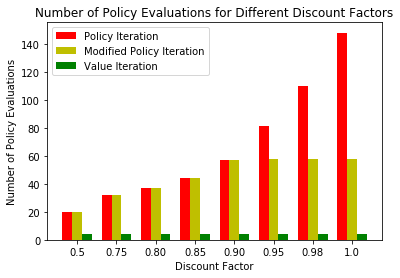

In [16]:
# Let's plot it instead!
import matplotlib.pyplot as plt
%matplotlib inline

ind = np.arange(num_tests)  # the x locations for the groups
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, tally_PE[:,0], width, color='r')
rects2 = ax.bar(ind + width, tally_PE[:,1], width, color='y')
rects3 = ax.bar(ind + 2*width, tally_PE[:,2], width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Policy Evaluations')
ax.set_xlabel('Discount Factor')
ax.set_title('Number of Policy Evaluations for Different Discount Factors')
ax.set_xticks(ind + width)
ax.set_xticklabels(('0.5', '0.75', '0.80', '0.85', '0.90', '0.95', '0.98', '1.0'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('Policy Iteration', 'Modified Policy Iteration', 'Value Iteration'))

Amazing. Value iteration in this case converges in 4 iterations. The modified policy evaluation plateaus again for discount factors greater than 0.95. Now let's see if the policies are the same for the policy iteration case of low and high discount factor.

In [17]:
# Policy Iteration comparison
# 0.50 Discount Factor
policy_50, v = policy_improvement(env, discount_factor=0.50)
print("0.50 Discount Factor")
print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v.reshape(env.shape))
print("")

# 1.00 Discount Factor
policy_100, v = policy_improvement(env, discount_factor=1.)
print("1.00 Discount Factor")
print("Policy Probability Distribution:")
print(policy)
print("")

print("Value Function:")
print(v.reshape(env.shape))
print("")

# Are both policies the same? It's hard to compare by eye
# if there are ones in the matrix, then no, if 0s and 2s, then yes
print policy_50+policy_100    

0.50 Discount Factor
Policy Probability Distribution:
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

Value Function:
[[ 0.   -1.   -1.5  -1.75]
 [-1.   -1.5  -1.75 -1.5 ]
 [-1.5  -1.75 -1.5  -1.  ]
 [-1.75 -1.5  -1.    0.  ]]

1.00 Discount Factor
Policy Probability Distribution:
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]

Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

[[ 0.  0.  0.  2.]
 [ 0.  0.  0.  2.]
 [ 0.  0.  0.  2.]
 [ 

So both policies are the same. The values are not because of the short and far-sightedness differences of both agents.

---